In [1]:
#!/usr/bin/env python

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import library
import sindy

In [3]:
import neuromancer.psl as psl
from neuromancer.system import Node, System
from neuromancer.modules import blocks
from neuromancer.modules.activations import activations
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem
from neuromancer.trainer import Trainer
from neuromancer.dynamics import ode, integrators
from neuromancer.plot import pltCL, pltPhase
torch.manual_seed(0)
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
nonlin_system_name = "Reno_ROM40"
nonlin_system = psl.systems[nonlin_system_name]
nonlin_sys = nonlin_system(seed=59)

system_name = "LinearReno_ROM40"
system = psl.systems[system_name]
sys = system()

In [5]:
ts = sys.ts
nx = sys.nx
ny = sys.ny
nu = sys.nu
nd = sys.nd
nd_obs = sys.nD_obs
nref = ny

umin = torch.tensor(sys.umin, device=dev)
umax = torch.tensor(sys.umax, device=dev)

In [6]:
def normalize(x, mean, std): 
    return ((x-mean)/std).nan_to_num()
def denormalize(x, mean, std): 
    return ((x*std)+mean).nan_to_num()

In [7]:
umean = torch.tensor(sys.stats['U']['mean'], device=dev)
ustd = torch.tensor(sys.stats['U']['std'], device=dev)
xmean = torch.tensor(sys.stats['X']['mean'], device=dev)
xstd = torch.tensor(sys.stats['X']['std'], device=dev)
ymean = torch.tensor(sys.stats['Y']['mean'], device=dev)
ystd = torch.tensor(sys.stats['Y']['std'], device=dev)
dmean = torch.tensor(sys.stats['Dhidden']['mean'], device=dev)
dstd = torch.tensor(sys.stats['Dhidden']['std'], device=dev)

umin = normalize(umin, umean, ustd)
umax = normalize(umax, umean, ustd)

In [8]:
A = torch.tensor(sys.A, device=dev)
B = torch.tensor(sys.Beta, device=dev)
C = torch.tensor(sys.C, device=dev)
E = torch.tensor(sys.E, device=dev)
F = torch.tensor(sys.F, device=dev)
G = torch.tensor(sys.G, device=dev)
y_ss = torch.tensor(sys.y_ss, device=dev)

In [9]:
def ssm_forward(x, u, d):
    x = denormalize(x, xmean, xstd)
    u = denormalize(u, umean, ustd)
    d = denormalize(d, dmean, dstd)

    x = x @ A.T + u @ B.T + d @ E.T + G.T
    y = x @ C.T + F.T  - y_ss

    x = normalize(x, xmean, xstd)
    y = normalize(y, ymean, ystd)
    return x, y

dist_obs = Node(lambda d: d[:, sys.d_idx], ['d'], ['d_obs'])

In [10]:
def get_policy_data(sys, nsteps, n_samples, xmin_range, batch_size, name="train"):
    #  sampled references for training the policy
    batched_xmin = xmin_range.sample((n_samples, 1, nref)).repeat(1, nsteps + 1, 1).to(dev)
    batched_xmax = batched_xmin + 2.

    # sampled disturbance trajectories from the simulation model
    batched_dist = torch.stack([torch.tensor(nonlin_sys.get_D(nsteps), device=dev) for _ in range(n_samples)])

    # sampled nonlinial conditions
    batched_x0 = torch.stack([torch.tensor(nonlin_sys.get_x0(), device=dev).unsqueeze(0) for _ in range(n_samples)])

    data = DictDataset(
        {"x": normalize(batched_x0, xmean, xstd),
         "ymin": normalize(batched_xmin, ymean, ystd),
         "ymax": normalize(batched_xmax, ymean, ystd),
         "d": normalize(batched_dist, dmean, dstd),
         "umin": umin.repeat((n_samples, nsteps, 1)),
         "umax": umax.repeat((n_samples, nsteps, 1)),
         "y": normalize(batched_x0 @ C.T + F.T - y_ss, ymean, ystd)
         
        },
        name=name,
    )
    return DataLoader(data, batch_size=batch_size, collate_fn=data.collate_fn, shuffle=False)

In [11]:
nsteps_test = 1000

x0 = torch.tensor(nonlin_sys.get_x0(), device=dev).reshape(1, 1, nx)
torch_dist = torch.tensor(nonlin_sys.get_D(nsteps_test+1), device=dev).unsqueeze(0)

np_refs = psl.signals.step(nsteps_test+1, nref, min=18., max=22., randsteps=3, rng=np.random.default_rng(seed=5))
ymin_val = torch.tensor(np_refs, dtype=torch.float32, device=dev).reshape(1, nsteps_test+1, nref)
ymax_val = ymin_val+2.0

data = {
        "x": normalize(x0, xmean, xstd),
         "ymin": normalize(ymin_val, ymean, ystd),
         "ymax": normalize(ymax_val, ymean, ystd),
         "d": normalize(torch_dist, dmean, dstd),
         "umin": umin.repeat(nsteps_test, 1),
         "umax": umax.repeat(nsteps_test, 1),
         "y": normalize(x0 @ C.T + F.T - y_ss, ymean, ystd)

}

In [12]:
def update_weights(coef, q, epsilon):
    return torch.diag(1 / (coef.flatten()**q + epsilon))

In [13]:
action_weight = 0.1
state_weight = 50.
du_weight = 0.0
u_bound_weight = 1.

def train_func(optim, system, sparsity):
    nsteps = system.nsteps
    # variables
    y = variable('y')
    u = variable('u')
    ymin_val = variable('ymin')
    ymax_val = variable('ymax')
    umin_val = variable('umin')
    umax_val = variable('umax')
    
    l = variable([y], lambda y: torch.norm(list(system.parameters())[0], p))

    loss_l = sparsity*((l == 0))
    
    action_loss = action_weight * ((u == 0.0))  # energy minimization
    du_loss = du_weight * (u[:,:-1,:] - u[:,1:,:] == 0.0)  # delta u minimization to prevent agressive changes in control actions
    
    state_lower_bound_penalty = state_weight*(y > ymin_val)
    state_upper_bound_penalty = state_weight*(y < ymax_val)

    u_lower_bound_penalty = u_bound_weight*(u > umin_val)
    u_upper_bound_penalty = u_bound_weight*(u < umax_val)

    constraints = [state_lower_bound_penalty, state_upper_bound_penalty, u_lower_bound_penalty, u_upper_bound_penalty]
    objectives = [action_loss, loss_l]
    
    components = [system]

    train_loader, dev_loader = [
            get_policy_data(sys, nsteps, n_samples, xmin_range, batch_size, name=name)
            for name in ("train", "dev")]   
    loss = PenaltyLoss(objectives, constraints)
    problem = Problem(components, loss)
    trainer = Trainer(
        problem,
        train_loader,
        dev_loader,
        optimizer=optim,
        epochs=50000//system.nsteps,
        train_metric='train_loss',
        eval_metric='dev_loss',
        patience=5000//system.nsteps,
        epoch_verbose=1,
        device=dev
    )
    
    # Train control policy
    best_model = trainer.train()
    
    # load best trained model
    trainer.model.load_state_dict(best_model)


    system.nsteps = nsteps
    trainer.badcount = 0

In [14]:
def test(test_data):

    trajectories_sindy = test_data

    sindy_y = denormalize(trajectories_sindy['y'], ymean, ystd)
    sindy_u = denormalize(trajectories_sindy['u'], umean, ustd)

    y_min = denormalize(test_data["ymin"], ymean, ystd)
    y_max = denormalize(test_data["ymax"], ymean, ystd)

    u_min = denormalize(test_data["umin"], umean, ustd)
    u_max = denormalize(test_data["umax"], umean, ustd)
    
    u_loss = action_weight * torch.sum(torch.abs(sindy_u))

    y_lower = torch.sum(torch.abs(torch.max(sindy_y - y_max, torch.zeros(sindy_y.shape, device=dev))))
    y_upper = torch.sum(torch.abs(torch.min(sindy_y - y_min, torch.zeros(sindy_y.shape, device=dev))))

    u_lower = torch.sum(torch.abs(torch.max(sindy_u - u_max, torch.zeros(sindy_u.shape, device=dev))))
    u_upper = torch.sum(torch.abs(torch.min(sindy_u - u_min, torch.zeros(sindy_u.shape, device=dev))))
    

    return (u_loss + state_weight*y_lower +  state_weight*y_upper + 10*u_lower + 10*u_upper).item()

In [15]:
torch.manual_seed(0)

n_samples = 3000    # number of sampled scenarios
batch_size = 1500
xmin_range = torch.distributions.Uniform(18., 22.)

max_degree = 1
max_freq = 3
sparsity = 0
p = 1
theta_1 = library.FourierLibrary(ny, 2*nref+nd_obs, max_freq=max_freq, include_cos=False)
theta_2 = library.PolynomialLibrary(ny, 2*nref+nd_obs, max_degree=max_degree, interaction=False)
names = ['1', 'y0', 'y1', 'y2', 'y3', 'y4', 'y5',
        'y0_min', 'y1_min', 'y2_min', 'y3_min', 'y4_min', 'y5_min',
        'y0_max', 'y1_max', 'y2_max', 'y3_max', 'y4_max', 'y5_max',
         'd']
theta_2.function_names = names

In [16]:
torch.cuda.empty_cache()

In [17]:
nsteps = 100
poly_sindy = sindy.SINDy(theta_2, n_out=nu)  
u_bound_node = Node(lambda u: torch.clamp(u, umin, umax), ['u_un'], ['u'])
policy_node = Node(poly_sindy,  ['y', 'R'], ['u']).to(dev)
combined_y = Node(lambda ymin, ymax, d: torch.cat([ymin, ymax, d], dim=-1),
              ['ymin', 'ymax', 'd_obs'], ['R'], name="y")
ssm = Node(ssm_forward, ['x', 'u', 'd'], ['x', 'y'])
poly_system = System([dist_obs, combined_y, policy_node, ssm],
                nsteps=nsteps,
                name='sindy_system').to(dev)
optimizer = torch.optim.AdamW(poly_sindy.parameters(), lr=.06)

In [18]:
train_func(optimizer, poly_system, sparsity)

/Users/cjb873/miniconda3/envs/neuromancer/lib/python3.10/site-packages/neuromancer/constraint.py:169: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1500, 100, 6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(left, right)


epoch: 0  train_loss: 4473081.0
epoch: 1  train_loss: 31802.3515625
epoch: 2  train_loss: 1685.4794921875
epoch: 3  train_loss: 271.1192932128906
epoch: 4  train_loss: 80.7154312133789
epoch: 5  train_loss: 91.18077087402344
epoch: 6  train_loss: 71.05005645751953
epoch: 7  train_loss: 48.512943267822266
epoch: 8  train_loss: 32.58677673339844
epoch: 9  train_loss: 27.521697998046875
epoch: 10  train_loss: 30.957847595214844
epoch: 11  train_loss: 29.180757522583008
epoch: 12  train_loss: 20.811485290527344
epoch: 13  train_loss: 18.098613739013672
epoch: 14  train_loss: 18.220806121826172
epoch: 15  train_loss: 17.95406150817871
epoch: 16  train_loss: 16.913204193115234
epoch: 17  train_loss: 14.880512237548828
epoch: 18  train_loss: 13.249059677124023
epoch: 19  train_loss: 12.748224258422852
epoch: 20  train_loss: 13.04444408416748
epoch: 21  train_loss: 12.164356231689453
epoch: 22  train_loss: 11.356456756591797
epoch: 23  train_loss: 10.75558090209961
epoch: 24  train_loss: 10.42

In [19]:
nsteps = 100

four_sindy = sindy.SINDy(theta_1, n_out=nu)  
policy_node = Node(four_sindy,  ['y', 'R'], ['u']).to(dev)

four_system = System([dist_obs, combined_y, policy_node, ssm],
                nsteps=nsteps,
                name='sindy_system').to(dev)
optimizer = torch.optim.AdamW(four_sindy.parameters(), lr=.06)

In [20]:
train_func(optimizer, four_system, sparsity)

epoch: 0  train_loss: 60.020233154296875
epoch: 1  train_loss: 48.07664108276367
epoch: 2  train_loss: 41.44373321533203
epoch: 3  train_loss: 36.01013946533203
epoch: 4  train_loss: 29.824779510498047
epoch: 5  train_loss: 24.045005798339844
epoch: 6  train_loss: 20.549530029296875
epoch: 7  train_loss: 18.998756408691406
epoch: 8  train_loss: 18.415504455566406
epoch: 9  train_loss: 17.493003845214844
epoch: 10  train_loss: 15.875038146972656
epoch: 11  train_loss: 14.574111938476562
epoch: 12  train_loss: 13.833148956298828
epoch: 13  train_loss: 13.18088150024414
epoch: 14  train_loss: 12.219797134399414
epoch: 15  train_loss: 11.09024429321289
epoch: 16  train_loss: 9.981406211853027
epoch: 17  train_loss: 9.300466537475586
epoch: 18  train_loss: 8.687773704528809
epoch: 19  train_loss: 8.33029556274414
epoch: 20  train_loss: 8.140369415283203
epoch: 21  train_loss: 7.9215617179870605
epoch: 22  train_loss: 7.839729309082031
epoch: 23  train_loss: 7.763460636138916
epoch: 24  trai

In [21]:
# Add bounds to u

policy_node_poly = Node(poly_sindy,  ['y', 'R'], ['u_un']).to(dev)

poly_system = System([dist_obs, combined_y, policy_node_poly, u_bound_node, ssm],
                nsteps=nsteps,
                name='sindy_system').to(dev)

policy_node_four = Node(four_sindy,  ['y', 'R'], ['u_un']).to(dev)

four_system = System([dist_obs, combined_y, policy_node_four, u_bound_node, ssm],
                nsteps=nsteps,
                name='sindy_system').to(dev)

In [22]:
poly_system.nsteps = nsteps_test
four_system.nsteps = nsteps_test

In [23]:
trajectories_poly = poly_system(data)
trajectories_four = four_system(data)

In [24]:
poly_y = denormalize(trajectories_poly['y'], ymean, ystd)
poly_u = denormalize(trajectories_poly['u'], umean, ustd)
four_y = denormalize(trajectories_four['y'], ymean, ystd)
four_u = denormalize(trajectories_four['u'], umean, ustd)

y_min = denormalize(data["ymin"], ymean, ystd)
y_max = denormalize(data["ymax"], ymean, ystd)

u_min = denormalize(data["umin"], umean, ustd)
u_max = denormalize(data["umax"], umean, ustd)
loss_poly = test(trajectories_poly)
loss_four = test(trajectories_four)

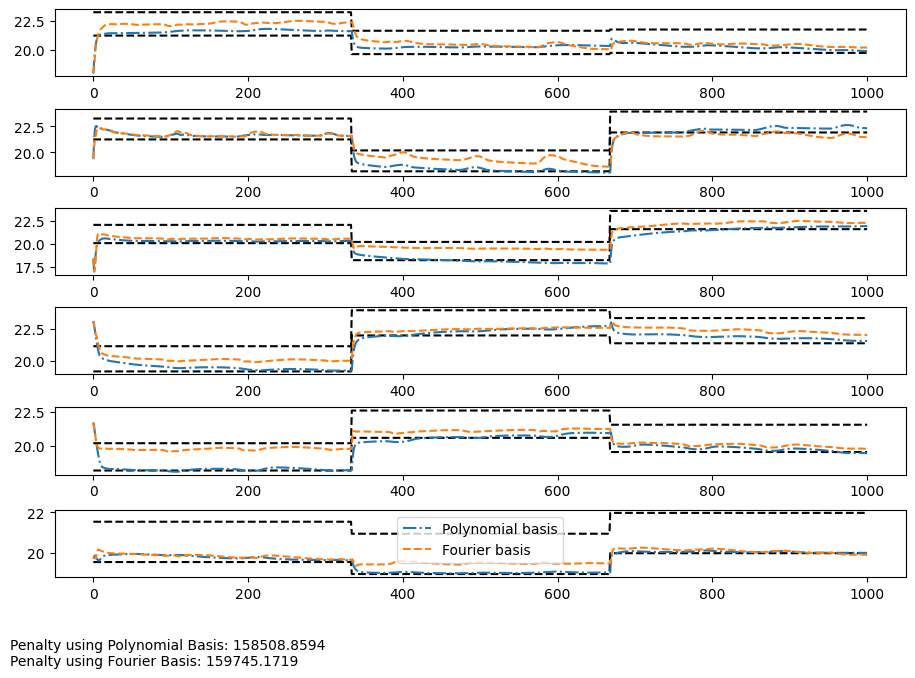

In [25]:
fig, ax = plt.subplots(nrows=ny, constrained_layout=True, figsize=(9,6))
for i in range(ny):
    ax[i].plot(y_min.cpu().numpy().reshape(-1, ny)[:,i], "--", color="black")
    ax[i].plot(y_max.cpu().numpy().reshape(-1, ny)[:,i], "--", color="black")
    ax[i].plot(poly_y.cpu().detach().numpy().reshape(nsteps_test+1, ny)[:,i], '-.', label='Polynomial basis')
    ax[i].plot(four_y.cpu().detach().numpy().reshape(nsteps_test+1, ny)[:,i], '--', label='Fourier basis')

fig.text(0, -0.1, 
           f"Penalty using Polynomial Basis: {loss_poly:.4f}\n"
           f"Penalty using Fourier Basis: {loss_four:.4f}")

plt.legend()

#plt.savefig("fourier_polynomial_hard_y.png")

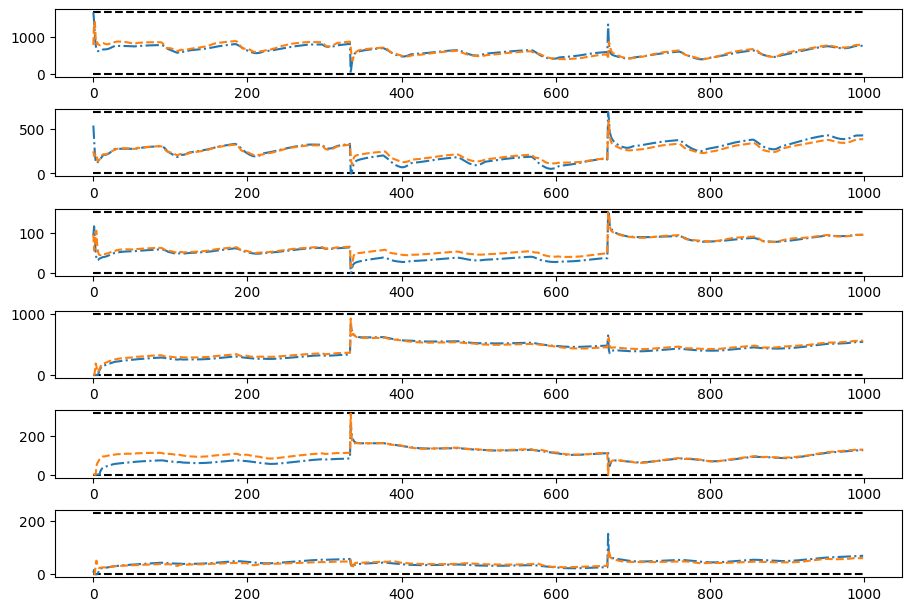

In [26]:
fig, ax = plt.subplots(nrows=nu, constrained_layout=True, figsize=(9,6))
for i in range(nu):
    ax[i].plot(u_min.cpu().numpy().reshape(-1, nu)[:,i], "--", color="black")
    ax[i].plot(u_max.cpu().numpy().reshape(-1, nu)[:,i], "--", color="black")
    ax[i].plot(poly_u.cpu().detach().numpy().reshape(nsteps_test, nu)[:,i], '-.',label='Polynomial basis')
    ax[i].plot(four_u.cpu().detach().numpy().reshape(nsteps_test, nu)[:,i], '--',label='Fourier basis')

#plt.savefig("fourier_polynomial_hard_u.png")